In [115]:
import pandas as pd
import re
pd.set_option('display.max_colwidth', 200)

# df = pd.read_json("guardian_world_structured_data/data_00004.jsonl", lines=True)
df = pd.read_json("/Users/yangqian/Downloads/commoncrawl/sample_1000_featured/data_00001.jsonl", lines=True)

USE_FILTER = True

# 1️⃣ 合并所有 tag 列
df['all_tags'] = df[['signposting_tags', 'section_labels', 'keyword_tags']].apply(
    lambda row: sum(
        (row[col] if isinstance(row[col], list) else []
        for col in ['signposting_tags', 'section_labels', 'keyword_tags']),
        []
    ),
    axis=1
)

# 2️⃣ 转成字符串方便模糊匹配
df['all_tags_str'] = df['all_tags'].apply(lambda tags: ' '.join(tags).lower())

if USE_FILTER:
    # 3️⃣ 定义想要的关键词（正选）
    include_keywords = [
        # 🌍 国际与全球事务
        'world', 'international', 'global', 'foreign', 'diplomacy', 'geopolitics',
        'conflict', 'war', 'security', 'defense', 'military', 'foreign affairs',

        # 🏛️ 政治与公共政策
        'politics', 'policy', 'government', 'election', 'parliament', 'democracy',
        'minister', 'president', 'prime minister', 'embassy', 'law', 'justice',
        'society', 'rights', 'civil rights', 'freedom', 'protest', 'activism',

        # 💰 经济与商业
        'economy', 'economic', 'finance', 'business', 'trade', 'market',
        'investment', 'industry', 'corporate', 'inflation', 'tax', 'monetary',
        'bank', 'debt', 'growth', 'employment',

        # 🌐 国际组织与发展
        'united nations', 'imf', 'world bank', 'eu', 'nato', 'g7', 'g20',
        'development', 'inequality', 'poverty', 'migration', 'refugee', 'human rights',

        # 🧠 评论与分析
        'opinion', 'comment', 'editorial', 'analysis', 'viewpoint', 'perspective',

        # ⚙️ 科技政策与环境议题
        'tech', 'technology', 'science', 'climate', 'environment', 'energy',
        'policy debate', 'regulation', 'digital policy'
    ]

    # 4️⃣ 定义不想要的关键词（反选）
    exclude_keywords = [
        # ⚽ 体育类
        'sport', 'sports', 'football', 'soccer', 'tennis', 'cricket', 'golf',
        'rugby', 'basketball', 'athletics', 'olympics', 'f1', 'motorsport', 'world cup',

        # 🎭 娱乐与文化类
        'film', 'movie', 'cinema', 'music', 'art', 'design', 'fashion', 'culture',
        'books', 'literature', 'tv', 'television', 'radio', 'celebrity',
        'entertainment', 'theatre', 'drama', 'concert',

        # 🏡 生活方式类
        'lifestyle', 'food', 'recipes', 'travel', 'family', 'health', 'fitness',
        'home', 'garden', 'relationships', 'beauty', 'style', 'wellbeing',

        # 🧘 课程与非新闻内容
        'masterclasses', 'creative writing', 'courses',
        'gallery', 'quiz'
    ]

    # ⭐️ [优化点 1] 使用更精确的正则表达式进行全词匹配
    def count_matches(text, keywords):
        """统计匹配到的关键词数量（使用正则表达式确保全词匹配）"""
        count = 0
        for kw in keywords:
            # 使用 \b 来确保是独立的单词，例如 "art" 不会匹配 "article"
            if re.search(rf'\b{re.escape(kw)}\b', text, flags=re.IGNORECASE):
                count += 1
        return count

    # ⭐️ [修复点 2] 采用更严格的保留逻辑
    def keep_row(text):
        """
        根据正负关键词数量决定是否保留该行。
        """
        pos_count = count_matches(text, include_keywords)
        neg_count = count_matches(text, exclude_keywords)
        
        # 新的保留逻辑：
        # 1. 如果有负向词，正向词必须严格多于负向词才能保留。
        # 2. 如果完全没有负向词，只要有1个正向词就保留。
        if neg_count > 0:
            return pos_count > neg_count
        else:
            return pos_count >= 1

    # 计算哪些行应保留
    mask_keep = df['all_tags_str'].apply(keep_row)

    # ✅ 保留新闻内容尽可能多
    filtered_df = df[mask_keep].copy()
    dropped_df = df[~mask_keep].copy()

    df = filtered_df

# 检查之前被错误放入的行是否还在
problematic_row_exists = df['id'].eq(27).any()
print(f"之前被错误保留的行 (id=27) 是否还存在: {problematic_row_exists}\n")

print("--- 筛选后保留的数据 (前20条) ---")
print(df.head(20))

print("\n--- 被丢弃的数据 (随机5条) ---")
# 检查一下被丢弃的是否是我们不想要的
print(dropped_df[['id', 'all_tags_str']].sample(5, random_state=42))

之前被错误保留的行 (id=27) 是否还存在: False

--- 筛选后保留的数据 (前20条) ---
                                  id  \
2   02cd702fd1f0fc27a8594ff1d6e2bf40   
4   03cdeef692a5d9815187d328f77a9c85   
5   04206e51acfcf4793bf4f427c1c719d6   
6   05b1d223d0695a65976be3afeda5212f   
7   05981a27e87cdead5cd12ec3612e9683   
12  089b7f38919c3072ff63e4b6708ca52c   
13  085be3183fb3aa6293fa74f656224a9f   
16  091cc2ad114f4ec02d54ae7d79bd1904   
17  0a9dde52ee29c16e3a3ff5ae47486633   
18  0b094d6e2d8756482adf9bd7ec8011e6   
19  0ccd460d989e41ce4bd285f46088fc86   
21  0ff688b221945074c845bc471f7ec2d4   
22  119e488e74fa2f867acf8f4d308f1d58   
24  107659fecf81bd716357d5dd9d0380bc   
25  13ebe721919d656199ba8596758102c4   
30  1510bfdadabb63c8904857fa140d2fda   
32  1733fb9e78ef14b22d4a773795dae989   
36  18d2be88de82b8236ac3203fe8b78d2b   
37  1b12a38328a0a84fec9fecb16bbcae14   
38  1b18def734ecd9fad3a3ca03d9da5802   

                                                                             title  \
2                

📅 Time Range:
  Earliest publish time: 1999-01-17 05:42:25+00:00
  Latest publish time:   2020-10-04 20:01:41+00:00
  Time span:             7931 days 14:19:16
After conversion: datetime64[ns, UTC]
2   2010-07-28 09:49:13+00:00
4   2009-06-12 11:01:00+00:00
5   2014-05-13 11:28:07+00:00
6   2018-03-27 10:00:02+00:00
7   2015-04-23 09:23:10+00:00
Name: publish_time, dtype: datetime64[ns, UTC]

🕒 Articles per Year:
year
1999.0     1
2000.0     3
2001.0     2
2002.0     3
2003.0     2
2004.0     6
2005.0     5
2006.0     9
2007.0    11
2008.0    15
2009.0    16
2010.0    17
2011.0    21
2012.0    20
2013.0    20
2014.0    17
2015.0    14
2016.0    13
2017.0     8
2018.0     8
2019.0     5
2020.0     5
Name: count, dtype: int64


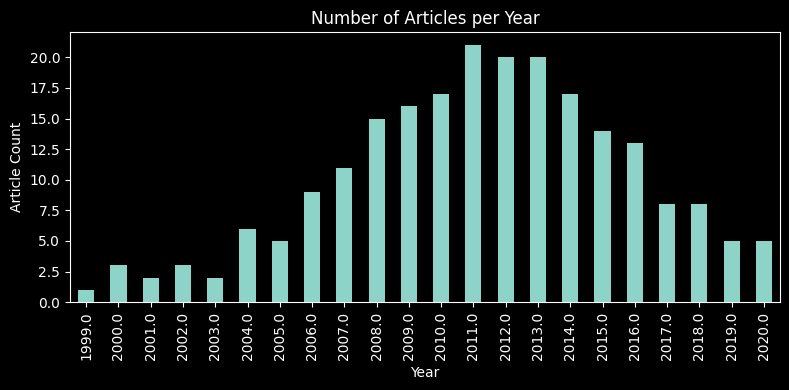


🧑‍💼 Author Statistics:
  Unique authors: 140

Top 10 Authors:
author
Unknown               52
Roy Greenslade         4
Monkey                 3
Nick Fletcher          3
Mark Tran              3
Suzanne Goldenberg     3
Steven Morris          3
Shaun Walker           2
Simon Bowers           2
Allegra Stratton       2
Name: count, dtype: int64


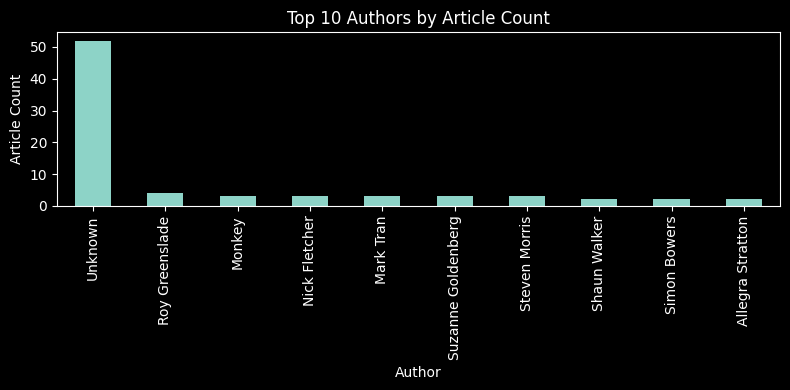


📏 Text Length Statistics:
count      222.000000
mean      3752.878378
std       2374.814913
min        198.000000
25%       2133.000000
50%       3343.000000
75%       4922.250000
90%       6455.400000
95%       7207.300000
99%      10662.610000
max      20974.000000
Name: text_len, dtype: float64


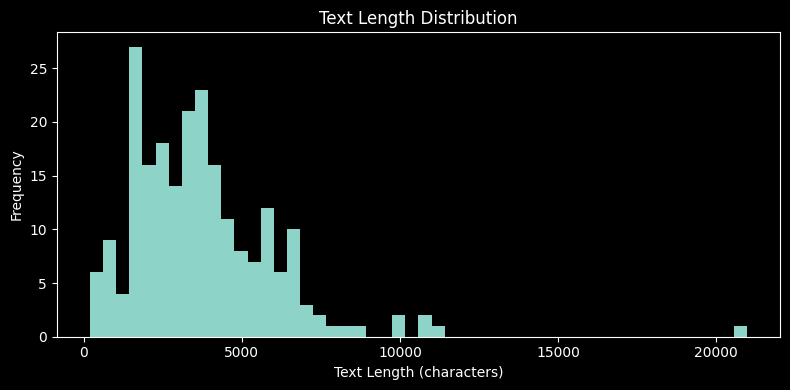


📰 Title Length Statistics:
count    222.000000
mean      52.617117
std       18.640497
min        7.000000
25%       39.000000
50%       55.000000
75%       67.000000
max       93.000000
Name: title_len, dtype: float64


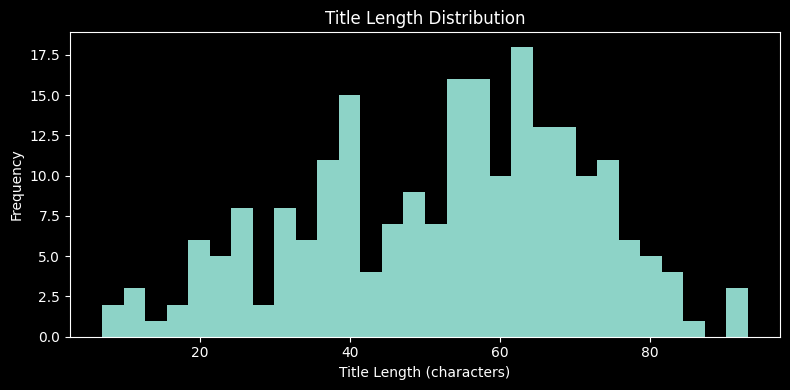

In [116]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert publish_time to datetime
df['publish_time'] = (
    df['publish_time']
    .astype(str)
    .str.strip()
    .apply(lambda x: pd.to_datetime(x, errors='coerce', utc=True))
)
invalid_times = df['publish_time'].isna().sum()

# ============ 1. Time Features ============
print("📅 Time Range:")
print(f"  Earliest publish time: {df['publish_time'].min()}")
print(f"  Latest publish time:   {df['publish_time'].max()}")
print(f"  Time span:             {df['publish_time'].max() - df['publish_time'].min()}")


# 检查转换结果
print("After conversion:", df['publish_time'].dtype)
print(df['publish_time'].head())
# 再创建 year 列
df['year'] = df['publish_time'].dt.year
# df['year'] = df['publish_time'].dt.year
year_counts = df['year'].value_counts().sort_index()
print("\n🕒 Articles per Year:")
print(year_counts)

plt.figure(figsize=(8,4))
year_counts.plot(kind='bar', title='Number of Articles per Year')
plt.xlabel('Year')
plt.ylabel('Article Count')
plt.tight_layout()
plt.show()


# ============ 2. Author Features ============
author_counts = df['author'].fillna('Unknown').value_counts()
print("\n🧑‍💼 Author Statistics:")
print(f"  Unique authors: {df['author'].nunique(dropna=True)}")
print("\nTop 10 Authors:")
print(author_counts.head(10))

plt.figure(figsize=(8,4))
author_counts.head(10).plot(kind='bar', title='Top 10 Authors by Article Count')
plt.xlabel('Author')
plt.ylabel('Article Count')
plt.tight_layout()
plt.show()


# ============ 3. Text Length Distribution ============
df['text_len'] = df['text'].str.len()
print("\n📏 Text Length Statistics:")
print(df['text_len'].describe(percentiles=[.25, .5, .75, .9, .95, .99]))

plt.figure(figsize=(8,4))
df['text_len'].plot(kind='hist', bins=50, title='Text Length Distribution')
plt.xlabel('Text Length (characters)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


# ============ 4. Title Length Distribution ============
df['title_len'] = df['title'].str.len()
print("\n📰 Title Length Statistics:")
print(df['title_len'].describe())

plt.figure(figsize=(8,4))
df['title_len'].plot(kind='hist', bins=30, title='Title Length Distribution')
plt.xlabel('Title Length (characters)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

📊 正在统计频率...
🎨 正在绘制图表...


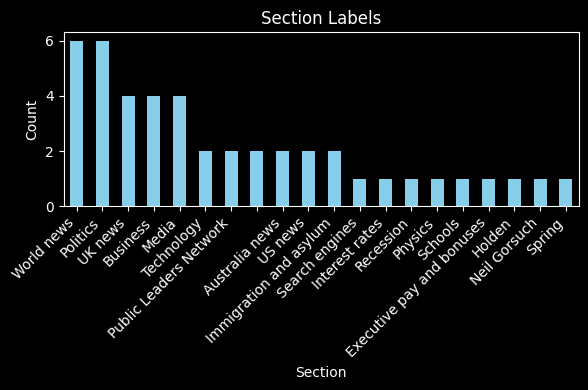

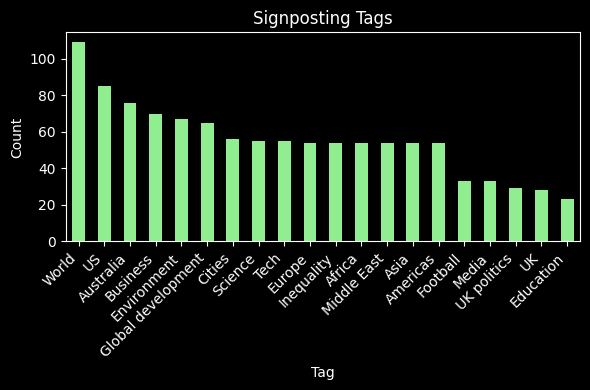

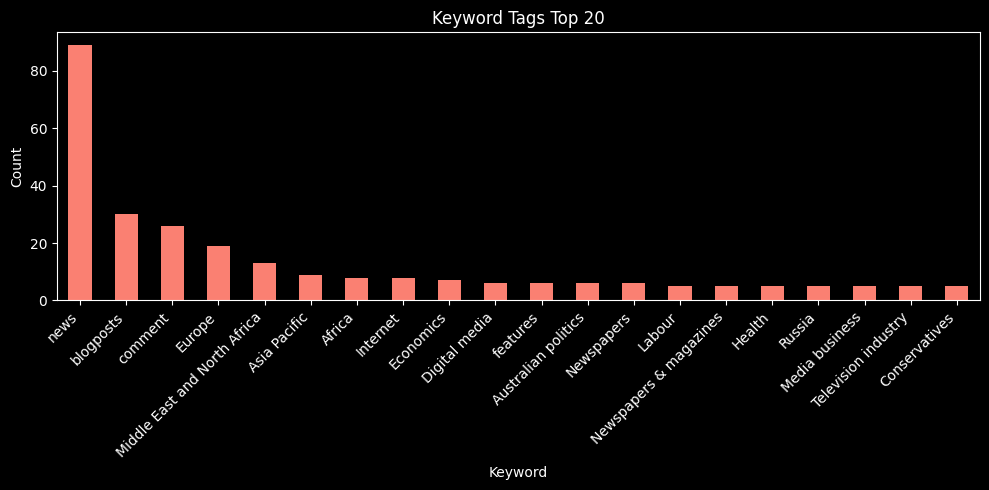

✅ 完成！图表已生成。


In [117]:
# 确保列存在
required_cols = ['signposting_tags', 'section_labels', 'keyword_tags']
missing_cols = [c for c in required_cols if c not in df.columns]
if missing_cols:
    raise ValueError(f"缺少列: {missing_cols}")

# ========== 统计 ==========
print("📊 正在统计频率...")

section_counts = df['section_labels'].explode().value_counts()
signposting_counts = df['signposting_tags'].explode().value_counts()
keyword_counts = df['keyword_tags'].explode().value_counts()

# ========== 绘图 ==========
print("🎨 正在绘制图表...")
TOP_N_KEYWORDS = 20

# ---------- 图 1: section_labels ----------
plt.figure(figsize=(6, 4))
# section_counts = section_counts.drop("World news", errors="ignore")
section_counts.head(TOP_N_KEYWORDS).plot(kind='bar', color='skyblue')
plt.title('Section Labels')
plt.xlabel('Section')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("section_labels_distribution.png")
plt.show()

# ---------- 图 2: signposting_tags ----------
plt.figure(figsize=(6, 4))
# signposting_counts = signposting_counts.drop("world", errors="ignore")
signposting_counts.head(TOP_N_KEYWORDS).plot(kind='bar', color='lightgreen')
plt.title('Signposting Tags')
plt.xlabel('Tag')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("signposting_tags_distribution.png")
plt.show()

# ---------- 图 3: keyword_tags ----------
plt.figure(figsize=(10, 5))
keyword_counts.head(TOP_N_KEYWORDS).plot(kind='bar', color='salmon')
plt.title(f'Keyword Tags Top {TOP_N_KEYWORDS}')
plt.xlabel('Keyword')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("keyword_tags_top.png")
plt.show()

print("✅ 完成！图表已生成。")

In [118]:
# import pandas as pd

# # 假设 df 已经加载
# # 1️⃣ 先合并所有 tag 列
# df['all_tags'] = df[['signposting_tags', 'section_labels', 'keyword_tags']].apply(
#     lambda row: sum((row[col] if isinstance(row[col], list) else [] for col in ['signposting_tags', 'section_labels', 'keyword_tags']), []),
#     axis=1
# )

# # 2️⃣ 把合并后的 tag 转成统一字符串（方便模糊匹配）
# df['all_tags_str'] = df['all_tags'].apply(lambda tags: ' '.join(tags).lower())

# # 3️⃣ 定义筛选关键词（政治经济与 world news）
# keywords = [
#     'world', 'politics', 'international', 'global',
#     'economy', 'economic', 'finance', 'business',
#     'foreign', 'trade', 'diplomacy', 'geopolitics'
# ]

# # 4️⃣ 过滤：只保留包含这些关键词的行
# mask = df['all_tags_str'].apply(lambda text: any(k in text for k in keywords))
# filtered_df = df[mask].copy()

# # 5️⃣ 查看结果
# print(filtered_df[['title', 'all_tags']].head())
# print(f"共筛选出 {len(filtered_df)} 条相关文章。")